# Using CellTypist for cell type classification
This notebook showcases the cell type classification for scRNA-seq query data by retrieving the most likely cell type labels from either the built-in CellTypist models or the user-trained custom models.

Only the main steps and key parameters are introduced in this notebook. Refer to detailed [Usage](https://github.com/Teichlab/celltypist#usage) if you want to learn more.

## Install CellTypist

In [24]:
from google.colab import drive
drive.mount('/content/drive')

!pip install scanpy
!pip install matplotlib==3.1.3
!pip install -U tensorflow
!pip install celltypist

import numpy as np 
import pandas as pd 
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scipy

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scanpy 1.9.1 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.5.2-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
import scanpy as sc

In [3]:
import celltypist
from celltypist import models

## Download a scRNA-seq dataset of 2,000 immune cells

In [4]:
adata_2000 = sc.read('celltypist_demo_folder/demo_2000_cells.h5ad', backup_url = 'https://celltypist.cog.sanger.ac.uk/Notebook_demo_data/demo_2000_cells.h5ad')

  0%|          | 0.00/34.1M [00:00<?, ?B/s]

This dataset includes 2,000 cells and 18,950 genes collected from different studies, thereby showing the practical applicability of CellTypist.

In [5]:
adata_2000.shape

(2000, 18950)

The expression matrix (`adata_2000.X`) is pre-processed (and required) as log1p normalised expression to 10,000 counts per cell (this matrix can be alternatively stashed in `.raw.X`).

In [6]:
adata_2000.X.expm1().sum(axis = 1)

matrix([[10000.   ],
        [10000.002],
        [10000.   ],
        ...,
        [10000.   ],
        [10000.   ],
        [10000.   ]], dtype=float32)

Some pre-assigned cell type labels are also in the data, which will be compared to the predicted labels from CellTypist later.

In [7]:
adata_2000.obs

,cell_type
cell1,Plasma cells
cell2,Plasma cells
cell3,Plasma cells
cell4,Plasma cells
cell5,Plasma cells
...,...
cell1996,Neutrophil-myeloid progenitor
cell1997,Neutrophil-myeloid progenitor
cell1998,Neutrophil-myeloid progenitor
cell1999,Neutrophil-myeloid progenitor


In [8]:
# Read and process GBM data 
GBM_adata = sc.read_text("/content/drive/MyDrive/ML for genomics project group /Data/GBM Data/Processed/GBM_LogX.txt", delimiter = '\t', first_column_names=None)
GBM_adata = GBM_adata.T 

# Regress out cell cycle scores
GBMCellCycleScores = pd.read_table("/content/drive/MyDrive/ML for genomics project group /Data/GBM Data/Processed/GbmCellCycleScores.txt", delimiter = '\t')
GBM_adata.obs['score_S'] = GBMCellCycleScores['score_S'].values
GBM_adata.obs['score_G2M'] = GBMCellCycleScores['score_G2M'].values
sc.pp.regress_out(GBM_adata, ['score_S', 'score_G2M'])

# Scale (zero-center) data
sc.pp.scale(GBM_adata)

# Load ground truth cell type labels 
GBM_Metadata = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/GBM Data/Processed/metadata2.csv")
GBM_adata.obs['Cell Type'] = GBM_Metadata['cell_assignment'].values

# Load gene list 
GBMGenes = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/GBM Data/Processed/features2.tsv",header=None)
GBMGenelist = []
for item in GBMGenes.values.tolist():
  GBMGenelist.append(item[0])
GBM_adata.var_names = GBMGenelist
GBM_adata.var_names

Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2MP1',
       'A4GALT', 'A4GNT', 'AA06',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=23686)

In [9]:
UnitNormalized_X = (GBM_adata.X - np.amin(GBM_adata.X)) / (np.amax(GBM_adata.X) - np.amin(GBM_adata.X))
GBM_adata.X = UnitNormalized_X 

sc.pp.normalize_total(GBM_adata, target_sum=10000)
sc.pp.log1p(GBM_adata)
GBM_adata.X = scipy.sparse.csr_matrix(GBM_adata.X)
GBM_adata.X.expm1().sum(axis = 1)

matrix([[10000.074],
        [10000.049],
        [10000.036],
        ...,
        [10000.04 ],
        [10000.03 ],
        [10000.074]], dtype=float32)

In [10]:
GBM_adata.raw = GBM_adata
GBM_adata

AnnData object with n_obs × n_vars = 7930 × 23686
    obs: 'score_S', 'score_G2M', 'Cell Type'
    var: 'mean', 'std'
    uns: 'log1p'

## Assign cell type labels using a CellTypist built-in model
In this section, we show the procedure of transferring cell type labels from built-in models to the query dataset.

Download the latest CellTypist models.

In [11]:
# Enabling `force_update = True` will overwrite existing (old) models.
models.download_models(force_update = True)

All models are stored in `models.models_path`.

In [12]:
models.models_path

'/root/.celltypist/data/models'

Get an overview of the models and what they represent.

In [13]:
models.models_description()

,model,description
0,Immune_All_Low.pkl,immune sub-populations combined from 20 tissue...
1,Immune_All_High.pkl,immune populations combined from 20 tissues of...
2,Adult_Mouse_Gut.pkl,cell types in the adult mouse gut combined fro...
3,COVID19_Immune_Landscape.pkl,immune subtypes from lung and blood of COVID-1...
4,Cells_Fetal_Lung.pkl,cell types from human embryonic and fetal lungs
5,Cells_Intestinal_Tract.pkl,"intestinal cells from fetal, pediatric and adu..."
6,Cells_Lung_Airway.pkl,cell populations from scRNA-seq of five locati...
7,Developing_Mouse_Brain.pkl,cell types from the embryonic mouse brain betw...
8,Healthy_COVID19_PBMC.pkl,peripheral blood mononuclear cell types from h...
9,Human_Lung_Atlas.pkl,integrated Human Lung Cell Atlas (HLCA) combin...


Choose the model you want to employ, for example, the model with all tissues combined containing low-hierarchy (high-resolution) immune cell types/subtypes.

In [40]:
# Indeed, the `model` argument defaults to `Immune_All_Low.pkl`.
model = models.Model.load(model = 'Immune_All_Low.pkl')

Show the model meta information.

In [41]:
model

CellTypist model with 98 cell types and 6639 features
    date: 2022-07-16 00:20:42.927778
    details: immune sub-populations combined from 20 tissues of 18 studies
    source: https://doi.org/10.1126/science.abl5197
    version: v2
    cell types: Age-associated B cells, Alveolar macrophages, ..., pDC precursor
    features: A1BG, A2M, ..., ZYX

This model contains 90 cell states.

In [42]:
model.cell_types

array(['Age-associated B cells', 'Alveolar macrophages', 'B cells',
       'CD16+ NK cells', 'CD16- NK cells', 'CD8a/a', 'CD8a/b(entry)',
       'CMP', 'CRTAM+ gamma-delta T cells', 'Classical monocytes',
       'Cycling B cells', 'Cycling DCs', 'Cycling NK cells',
       'Cycling T cells', 'Cycling gamma-delta T cells',
       'Cycling monocytes', 'DC', 'DC precursor', 'DC1', 'DC2', 'DC3',
       'Double-negative thymocytes', 'Double-positive thymocytes', 'ELP',
       'ETP', 'Early MK', 'Early erythroid', 'Early lymphoid/T lymphoid',
       'Endothelial cells', 'Epithelial cells', 'Erythrocytes',
       'Erythrophagocytic macrophages', 'Fibroblasts',
       'Follicular B cells', 'Follicular helper T cells', 'GMP',
       'Germinal center B cells', 'Granulocytes', 'HSC/MPP',
       'Hofbauer cells', 'ILC', 'ILC precursor', 'ILC1', 'ILC2', 'ILC3',
       'Intermediate macrophages', 'Intestinal macrophages',
       'Kidney-resident macrophages', 'Kupffer cells',
       'Large pre-B cell

Transfer cell type labels from this model to the query dataset using [celltypist.annotate](https://celltypist.readthedocs.io/en/latest/celltypist.html#module-celltypist.annotate).

In [43]:
# Not run; predict cell identities using this loaded model.
#predictions = celltypist.annotate(adata_2000, model = model, majority_voting = True)
# Alternatively, just specify the model name (recommended as this ensures the model is intact every time it is loaded).
predictions = celltypist.annotate(adata_2000, model = 'Immune_All_Low.pkl', majority_voting = True)

By default (`majority_voting = False`), CellTypist will infer the identity of each query cell independently. This leads to raw predicted cell type labels, and usually finishes within seconds or minutes depending on the size of the query data. You can also turn on the majority-voting classifier (`majority_voting = True`), which refines cell identities within local subclusters after an over-clustering approach at the cost of increased runtime.

The results include both predicted cell type labels (`predicted_labels`), over-clustering result (`over_clustering`), and predicted labels after majority voting in local subclusters (`majority_voting`). Note in the `predicted_labels`, each query cell gets its inferred label by choosing the most probable cell type among all possible cell types in the given model.

In [44]:
predictions.predicted_labels

,predicted_labels,over_clustering,majority_voting
cell1,Plasma cells,44,Plasma cells
cell2,Plasma cells,11,Plasma cells
cell3,Plasma cells,39,gamma-delta T cells
cell4,Plasma cells,2,Plasma cells
cell5,Plasma cells,2,Plasma cells
...,...,...,...
cell1996,HSC/MPP,36,Neutrophil-myeloid progenitor
cell1997,Neutrophil-myeloid progenitor,26,Neutrophil-myeloid progenitor
cell1998,Neutrophil-myeloid progenitor,27,Neutrophil-myeloid progenitor
cell1999,Neutrophil-myeloid progenitor,26,Neutrophil-myeloid progenitor


Transform the prediction result into an `AnnData`.

In [45]:
# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
adata = predictions.to_adata()

Compared to `adata_2000`, the new `adata` has additional prediction information in `adata.obs` (`predicted_labels`, `over_clustering`, `majority_voting` and `conf_score`). Of note, all these columns can be prefixed with a specific string by setting `prefix` in [to_adata](https://celltypist.readthedocs.io/en/latest/celltypist.html#celltypist.classifier.AnnotationResult.to_adata).

In [46]:
adata.obs

,cell_type,predicted_labels,over_clustering,majority_voting,conf_score
cell1,Plasma cells,Plasma cells,44,Plasma cells,0.999762
cell2,Plasma cells,Plasma cells,11,Plasma cells,0.999926
cell3,Plasma cells,Plasma cells,39,gamma-delta T cells,0.955991
cell4,Plasma cells,Plasma cells,2,Plasma cells,0.999883
cell5,Plasma cells,Plasma cells,2,Plasma cells,0.999890
...,...,...,...,...,...
cell1996,Neutrophil-myeloid progenitor,HSC/MPP,36,Neutrophil-myeloid progenitor,0.152962
cell1997,Neutrophil-myeloid progenitor,Neutrophil-myeloid progenitor,26,Neutrophil-myeloid progenitor,0.810408
cell1998,Neutrophil-myeloid progenitor,Neutrophil-myeloid progenitor,27,Neutrophil-myeloid progenitor,0.961021
cell1999,Neutrophil-myeloid progenitor,Neutrophil-myeloid progenitor,26,Neutrophil-myeloid progenitor,0.131777


In addition to this meta information added, the neighborhood graph constructed during over-clustering is also stored in the `adata` 
(If a pre-calculated neighborhood graph is already present in the `AnnData`, this graph construction step will be skipped).  
This graph can be used to derive the cell embeddings, such as the UMAP coordinates.

In [48]:
# If the UMAP or any cell embeddings are already available in the `AnnData`, skip this command.
sc.pp.pca(adata, use_highly_variable=False)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [29]:
!pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.5.2
Uninstalling matplotlib-3.5.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.2-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.5.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the pa

Visualise the prediction results.

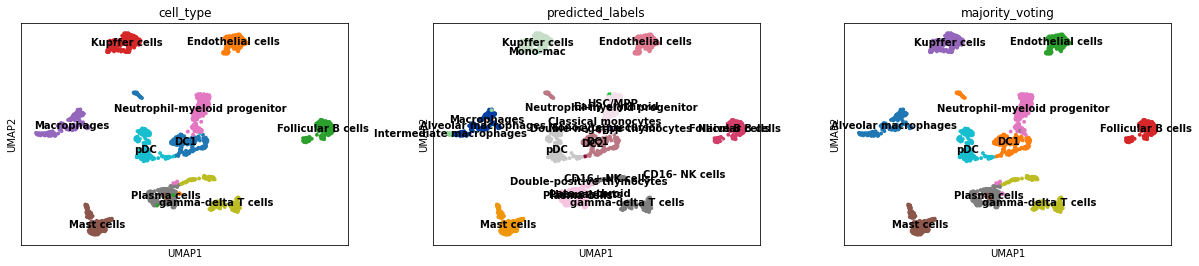

In [50]:
sc.pl.umap(adata, color = ['cell_type', 'predicted_labels', 'majority_voting'], legend_loc = 'on data')

Actually, you may not need to explicitly convert `predictions` output by `celltypist.annotate` into an `AnnData` as above. A more useful way is to use the visualisation function [celltypist.dotplot](https://celltypist.readthedocs.io/en/latest/celltypist.html#module-celltypist.plot), which quantitatively compares the CellTypist prediction result (e.g. `majority_voting` here) with the cell types pre-defined in the `AnnData` (here `cell_type`). You can also change the value of `use_as_prediction` to `predicted_labels` to compare the raw prediction result with the pre-defined cell types.

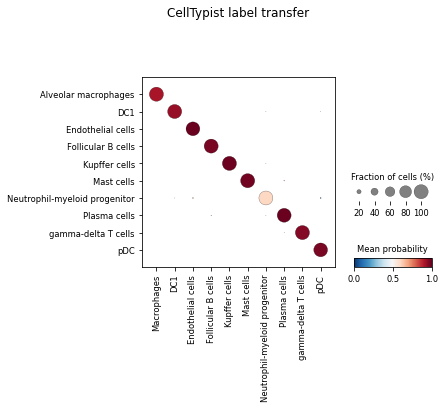

In [51]:
celltypist.dotplot(predictions, use_as_reference = 'cell_type', use_as_prediction = 'majority_voting')

For each pre-defined cell type (each column from the dot plot), this plot shows how it can be 'decomposed' into different cell types predicted by CellTypist (rows).

## Assign cell type labels using a custom model
In this section, we show the procedure of generating a custom model and transferring labels from the model to the query data.

Use previously downloaded dataset of 2,000 immune cells as the training set.

In [ ]:
adata_2000 = sc.read('celltypist_demo_folder/demo_2000_cells.h5ad', backup_url = 'https://celltypist.cog.sanger.ac.uk/Notebook_demo_data/demo_2000_cells.h5ad')

Download another scRNA-seq dataset of 400 immune cells as a query.

In [ ]:
adata_400 = sc.read('celltypist_demo_folder/demo_400_cells.h5ad', backup_url = 'https://celltypist.cog.sanger.ac.uk/Notebook_demo_data/demo_400_cells.h5ad')

  0%|          | 0.00/7.62M [00:00<?, ?B/s]

Derive a custom model by training the data using the [celltypist.train](https://celltypist.readthedocs.io/en/latest/celltypist.html#) function.

In [ ]:
# The `cell_type` in `adata_2000.obs` will be used as cell type labels for training.
new_model = celltypist.train(adata_2000, labels = 'cell_type', n_jobs = 10, feature_selection = True)

🍳 Preparing data before training
✂️ 2749 non-expressed genes are filtered out
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 2626 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!


Refer to the function [celltypist.train](https://celltypist.readthedocs.io/en/latest/celltypist.html#) for what each parameter means, and to the [usage](https://github.com/Teichlab/celltypist#usage) for details of model training.

This custom model can be manipulated as with other CellTypist built-in models. First, save this model locally.

In [ ]:
# Save the model.
new_model.write('celltypist_demo_folder/model_from_immune2000.pkl')

You can load this model by `models.Model.load`.

In [ ]:
new_model = models.Model.load('celltypist_demo_folder/model_from_immune2000.pkl')

Next, we use this model to predict the query dataset of 400 immune cells.

In [ ]:
# Not run; predict the identity of each input cell with the new model.
#predictions = celltypist.annotate(adata_400, model = new_model, majority_voting = True)
# Alternatively, just specify the model path (recommended as this ensures the model is intact every time it is loaded).
predictions = celltypist.annotate(adata_400, model = 'celltypist_demo_folder/model_from_immune2000.pkl', majority_voting = True)

🔬 Input data has 400 cells and 18950 genes
🔗 Matching reference genes in the model
🧬 2626 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


In [ ]:
adata = predictions.to_adata()

In [ ]:
sc.tl.umap(adata)

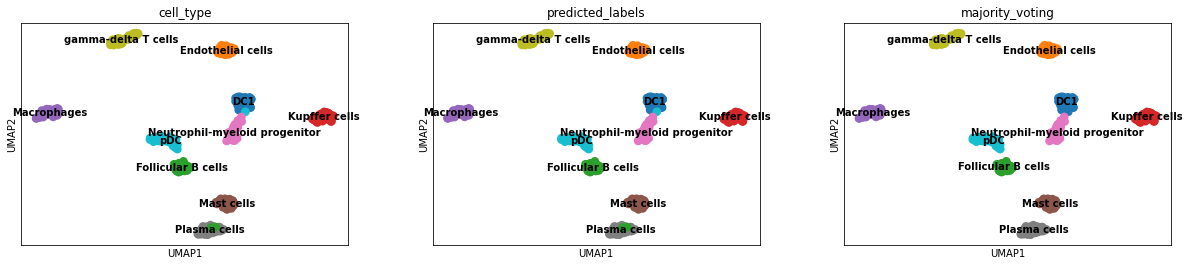

In [ ]:
sc.pl.umap(adata, color = ['cell_type', 'predicted_labels', 'majority_voting'], legend_loc = 'on data')

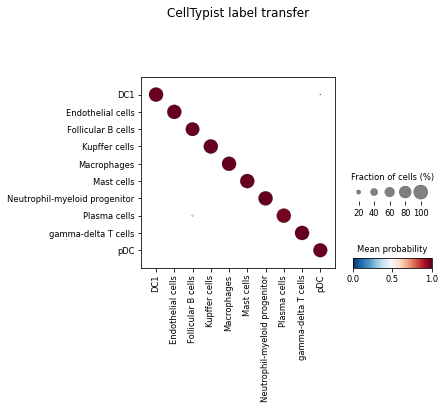

In [ ]:
celltypist.dotplot(predictions, use_as_reference = 'cell_type', use_as_prediction = 'majority_voting')

## Examine expression of cell type-driving genes

Each model can be examined in terms of the driving genes for each cell type. Note these genes are only dependent on the model, say, the training dataset.

In [ ]:
# Any model can be inspected.
# Here we load the previously saved model trained from 2,000 immune cells.
model = models.Model.load(model = 'celltypist_demo_folder/model_from_immune2000.pkl')

In [ ]:
model.cell_types

array(['DC1', 'Endothelial cells', 'Follicular B cells', 'Kupffer cells',
       'Macrophages', 'Mast cells', 'Neutrophil-myeloid progenitor',
       'Plasma cells', 'gamma-delta T cells', 'pDC'], dtype=object)

Extract the top three driving genes of `Mast cells` using the [extract_top_markers](https://celltypist.readthedocs.io/en/latest/celltypist.html#celltypist.models.Model.extract_top_markers) method.

In [ ]:
top_3_genes = model.extract_top_markers("Mast cells", 3)
top_3_genes

array(['TPSB2', 'TPSAB1', 'CPA3'], dtype=object)

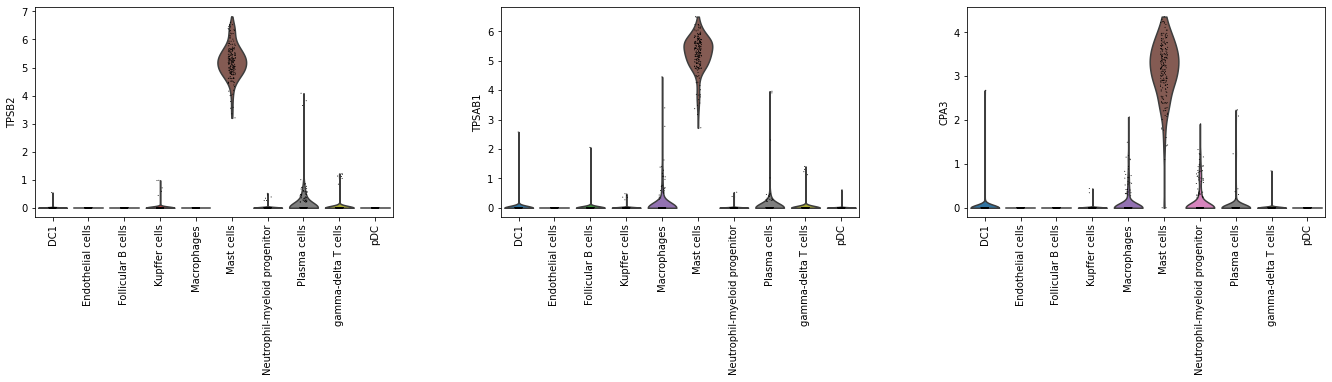

In [ ]:
# Check expression of the three genes in the training set.
sc.pl.violin(adata_2000, top_3_genes, groupby = 'cell_type', rotation = 90)

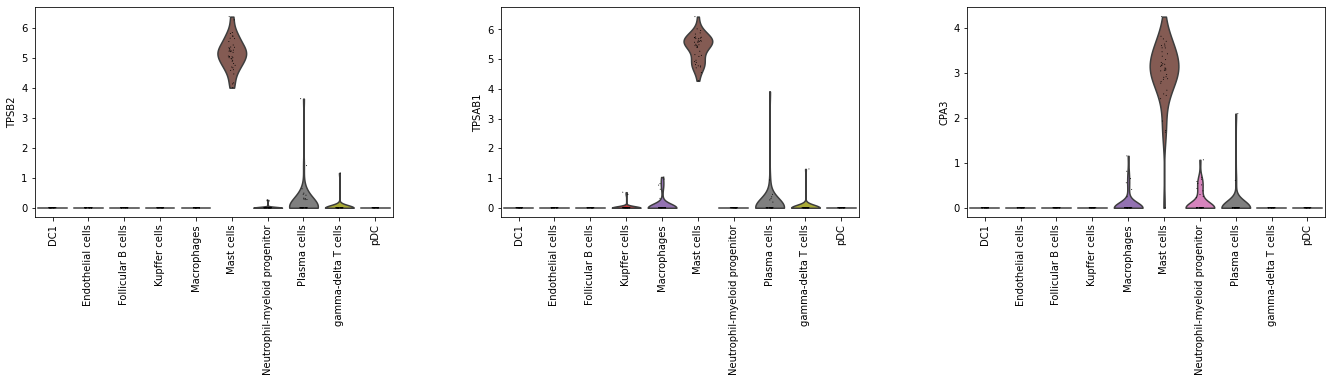

In [ ]:
# Check expression of the three genes in the query set.
# Here we use `majority_voting` from CellTypist as the cell type labels for this dataset.
sc.pl.violin(adata_400, top_3_genes, groupby = 'majority_voting', rotation = 90)